# LIGA NOS MYTH BUSTERS

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import bar_chart_race as bcr
import math
from os.path import join
import warnings
warnings.filterwarnings('ignore')

style = 'fivethirtyeight'

import re
from urllib import request
import requests
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set_style('darkgrid')
sns.set_palette(palette="ch:start=.2,rot=-.3")
%matplotlib inline


Int_Path = 'IntermediateData'
Dash_Path = r'DASH\assets'

start = time.time()

#### Functions for regular use + additional info

In [2]:
# Function 1: recursive function for finding a character (or, generally, a substring) in its nth occurrence in a string
def character_n(character, string, n):
    if n == 1:
        return string.find(character)
    else:
        return string.find(character, character_n(character, string, n-1) + 1)

# Function 2: check if a string has any digit
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)


dict_team_name = {'Academica': 'Académica',
                  'Académica OAF': 'Académica',
                  'FC Alverca': 'Alverca',
                  'FC Arouca': 'Arouca',
                  'Beira Mar': 'Beira-Mar',
                  'Os Belenenses': 'Belenenses',
                  'Belenenses SAD': 'Belenenses',
                  'B SAD': 'Belenenses',
                  'Boavista FC': 'Boavista',
                  'Campomaior': 'Campomaiorense',
                  'Aves': 'Desp. Aves',
                  'CD Aves': 'Desp. Aves',
                  'Chaves': 'Desp. Chaves',
                  'GD Chaves': 'Desp. Chaves',
                  'Estoril Praia': 'Estoril',
                  'Est Amadora': 'E. Amadora',
                  'Est. Amadora': 'E. Amadora',
                  'Famalicao': 'Famalicão',
                  'FC Famalicão': 'Famalicão',
                  'Porto': 'FC Porto',
                  'FC Felgueiras': 'Felgueiras',
                  'Gil Vicente FC': 'Gil Vicente',
                  'Leca': 'Leça',
                  'Leça FC': 'Leça',
                  'Leixoes': 'Leixões',
                  'Clube Sport Marítimo': 'Marítimo',
                  'Maritimo': 'Marítimo',
                  'Moreirense FC': 'Moreirense',
                  'Naval 1º Maio': 'Naval',
                  'FC Paços de Ferreira': 'Paços Ferreira',
                  'Pacos Ferreira': 'Paços Ferreira',
                  'Paços de Ferreira': 'Paços Ferreira',
                  'FC Penafiel': 'Penafiel',
                  'Portimonense SC': 'Portimonense',
                  'Rio Ave FC': 'Rio Ave',
                  'SC Salgueiros': 'Salgueiros',
                  'Sp Braga': 'SC Braga',
                  'Sp. Braga': 'SC Braga',
                  'Benfica': 'SL Benfica',
                  'Sp Lisbon': 'Sporting CP',
                  'Sporting': 'Sporting CP',
                  'Espinho': 'Sp. Espinho',
                  'SC Espinho': 'Sp. Espinho',
                  'CD Tondela': 'Tondela',
                  'Leiria': 'U. Leiria',
                  'UD Leiria': 'U. Leiria',
                  'Madeira': 'U. Madeira',
                  'Uniao Madeira': 'U. Madeira',
                  'União Madeira': 'U. Madeira',
                  'Vitória Guimarães': 'V. Guimarães',
                  'Guimaraes': 'V. Guimarães',
                  'Setubal': 'V. Setúbal',
                  'Vitória de Setúbal': 'V. Setúbal'
}

# I. DATA GATHERING AND PREPROCESSING ---------------------------------------------

## 1. Joining together all Liga NOS files in a single dataset, by scrapping **football-data.co.uk**

In [3]:
root_path = 'http://www.football-data.co.uk/'
portugal_path = root_path + 'portugalm.php'

# Parsing the url html to a python object 'html'
with request.urlopen(portugal_path) as data_source:
    html = data_source.read().decode('utf-8')

# Filtering the html for the chunks we need
Season_Identifier = 'Season'
Season_Position_html = [chunk.start() for chunk in re.finditer(Season_Identifier, html)]
csv_Identifier = 'P1.csv'
csv_Position_html = [chunk.start() for chunk in re.finditer(csv_Identifier, html)]

# Extracting the url for every season's csv file
Season_csv_chunk = []
for i in range(len(Season_Position_html)):
    Season_csv_chunk.append(html[Season_Position_html[i] : csv_Position_html[i] + len(csv_Identifier)])

# Joining the root_path with every url
file_identifier = 'mmz4281/yyyy/P1.csv'
csv_url = [root_path + season_file[-len(file_identifier):] for season_file in Season_csv_chunk]

# Creating a dataframe for storing the files
LigaNOS_files = pd.DataFrame({'File_url': csv_url})
LigaNOS_files['Season'] = LigaNOS_files['File_url'].map(lambda x: x[character_n('/', x, 4) + 1 : character_n('/', x, 5)]).astype('str')
LigaNOS_files['SeasonOrder'] = LigaNOS_files.index.map(lambda x: len(LigaNOS_files) - x)

# Appending together all files in a single dataset
df_liganos = pd.DataFrame()

for i in range(len(LigaNOS_files)):
    
    # files from seasons 0203, 0404 and 0607 are corrupted
    if i not in [13, 17, 18]:
        df = pd.read_csv(LigaNOS_files['File_url'][i]) \
               .dropna(axis=1, how='all')
        
        #Some preprocessing
        df = df[(df['HomeTeam'].notna())] # because some Seasons have noise rows, with just one or two columns filled with "random" values
        
        df['HomeTeam'] = df['HomeTeam'].str.strip()
        df['AwayTeam'] = df['AwayTeam'].str.strip()
        
        df.rename(columns = {'FTHG': 'HG',
                             'FTAG': 'AG',
                             'FTR': 'Res',
                             'PSH': 'PH',
                             'PSD': 'PD',
                             'PSA': 'PA'}, inplace = True) # Columns with two possible names - picking one of them
        df.insert(0, 'Season', LigaNOS_files['Season'][i])
        df['SeasonOrder'] = LigaNOS_files['SeasonOrder'][i]

        df['Date'] = pd.to_datetime(df['Date'])
        
        df_liganos = df_liganos.append(df, ignore_index = True)
        
df_liganos['HomeTeam'] = df_liganos['HomeTeam'].replace(dict_team_name)
df_liganos['AwayTeam'] = df_liganos['AwayTeam'].replace(dict_team_name)
        
# Variables
col_Results = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'HG', 'AG', 'Res', 'HTHG', 'HTAG', 'HTR']
col_Match_Statistics = ['Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
                        'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP']
col_1X2_betting_odds = ['B365H', 'B365D', 'B365A', 'BSH', 'BSD', 'BSA', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD',
                        'IWA', 'LBH', 'LBD', 'LBA', 'PH', 'PD', 'PA', 'SOH', 'SOD', 'SOA', 'SBH', 'SBD', 'SBA',
                        'SJH', 'SJD', 'SJA', 'SYH', 'SYD', 'SYA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Bb1X2', 'BbMxH',
                        'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']
col_total_goals_betting_odds = ['BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'GB>2.5', 'GB<2.5',
                                'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']
col_Asian_handicap_betting_odds = ['BbAH', 'BbAHh', 'AHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'GBAHH', 'GBAHA', 'GBAH', 'LBAHH',
                                   'LBAHA', 'LBAH', 'B365AHH', 'B365AHA', 'B365AH', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA']
col_last_odds_before_match_starts = ['B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA',
                                     'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA',
                                     'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh',
                                     'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']
LigaNOS_columns = col_Results \
                  + col_Match_Statistics \
                  + col_1X2_betting_odds \
                  + col_total_goals_betting_odds \
                  + col_Asian_handicap_betting_odds \
                  + col_last_odds_before_match_starts

# Checking which columns are not available in any season
not_available_columns = [column for column in LigaNOS_columns if column not in list(df_liganos.columns)]

df_liganos.to_csv(Dash_Path + r'\df_liganos.csv')
df_liganos

,Season,Div,Date,Time,HomeTeam,AwayTeam,HG,AG,Res,HTHG,...,SBA,GB>2.5,GB<2.5,GBAHH,GBAHA,GBAH,B365AH,SYH,SYD,SYA
0,2021,P1,2020-09-18,19:00,Famalicão,SL Benfica,1.0,5.0,A,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,P1,2020-09-18,21:15,V. Guimarães,Belenenses,0.0,1.0,A,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,P1,2020-09-19,16:00,Nacional,Boavista,3.0,3.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,P1,2020-09-19,21:00,FC Porto,SC Braga,3.0,1.0,H,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,P1,2020-09-20,16:00,Santa Clara,Marítimo,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,9495,P1,1995-05-28,NaN,U. Leiria,Beira-Mar,3.0,1.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6855,9495,P1,1995-05-28,NaN,Marítimo,Belenenses,3.0,0.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6856,9495,P1,1995-05-28,NaN,FC Porto,Tirsense,4.0,0.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6857,9495,P1,1995-05-28,NaN,V. Setúbal,U. Madeira,4.0,1.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1. Visualizing available columns for each season since 1994/95

<AxesSubplot:xlabel='Season'>

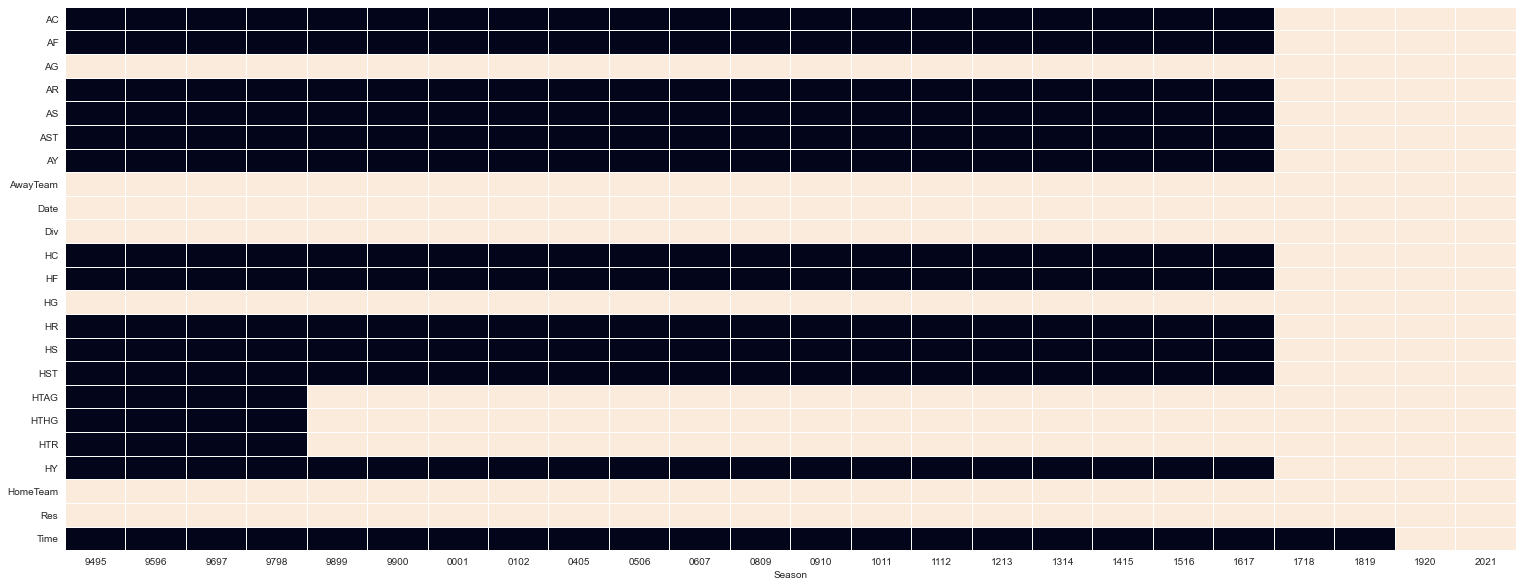

In [4]:
# Checking which columns are available for each season
visual_options = ['Restricted', 'Extended']
visual_choice = visual_options[0]  # By default, we only want to check results and match statistics. Feel free to input visual_options[1] for all columns 

if visual_choice == 'Extended':
    columns_to_check = df_liganos.columns
    figsize = (19, 33)
else:
    columns_to_check = np.setdiff1d(['Season', 'SeasonOrder'] + col_Results + col_Match_Statistics, not_available_columns)
    figsize = (26, 10)

df_columns_test = df_liganos.copy()[columns_to_check]

df_columns_test = df_columns_test.groupby(['SeasonOrder', 'Season']) \
                                 .count() \
                                 .sort_index() \
                                 .reset_index() \
                                 .drop(columns = ['SeasonOrder']) \
                                 .set_index('Season') \
                                 .T

len_df_columns_test = len(df_columns_test)

df_columns_test = df_columns_test.applymap(lambda x: 1 if x > 0 else 0)

plt.figure(figsize = figsize)

sns.heatmap(df_columns_test, linewidths = 0.01, linecolor = 'white', cbar = False)

## 2. Scrapping **futebol365.pt**, for finding out the round of each game

Further ahead, we're interested in apprasing how things went along the seasons, and the most common way of doing it is along rounds. We could simplify and assume that every n / 2 games (where n is the number of teams on a given season) constitute a round. However, some games are postponed or anticipated due to weather conditions, calendar adjustments to fit european games, and so on. Therefore, in some seasons we would see a team play more than one time in a round, and others not playing in a given round.

To overcome this handicap, we went on to scrap futebol365.pt for the round of each game, for all seasons since 1994/1995, using the Beautiful Soup package:

In [5]:
# JornadaRes = []
# EquipasRes1 = []
# EquipasRes2 = []
# Temporada = []

# for season in range(1994,2021):

#     season_years = str(season)[-2:] + str(season + 1)[-2:]

#     # Each season has 2(n - 1) games, where n is the number of teams for that season
#     rounds = (len(df_liganos[df_liganos['Season'] == season_years]['HomeTeam'].unique()) - 1) * 2 

#     for round in range(1, rounds + 1):
#         if int(season_years) == 1314:
#             URL = 'https://www.futebol365.pt/competicao/392/?edition=' \
#                   + str(season) \
#                   + '&group=all&competition_phase=Campeonato&phase_round=' \
#                   + str(round)
#         else:
#             URL = 'https://www.futebol365.pt/competicao/392/?edition=' \
#                   + str(season) \
#                   + '&competition_round=' \
#                   + str(round) \
#                   + '&group=all'

#         page = requests.get(URL)
#         soup = BeautifulSoup(page.content, 'html.parser')

#         #JORNADAS
#         results = soup.find(class_ = 'ink-grid all-container')
#         job_elems = results.find_all('section', class_ = 'left-column-group')

#         for job_elem in job_elems:
#             result = job_elem.find('h5', class_ = 'headerTitleSimpleBackground')

#             Equipas = soup.find(class_='left-column-group')
#             job_equipas = Equipas.find_all('table', class_='ink-table ink-table-f365 alternating all-100')
#             for job_equipa in job_equipas:
#                 result_equipa = job_equipa.find_all('td', class_='align-left hide-xlarge hide-large hide-medium')
#                 for res_equipa in result_equipa:
#                     if (hasNumbers(res_equipa.text[0]) == False):

#                         EquipasRes1.append(res_equipa.text.split('\n')[1])
#                         EquipasRes2.append(res_equipa.text.split('\n')[3])
#                         Temporada.append(str(season)+'-'+str(season+1))
#                         JornadaRes.append(result.text.split("ª")[0])
                        
# df_rounds = pd.DataFrame(list(zip(Temporada,JornadaRes, EquipasRes1, EquipasRes2)),
#                          columns =['Season', 'Round', 'HomeTeam', 'AwayTeam'])

# df_rounds.to_csv(Int_Path + r'\df_rounds.csv')

Since the code above takes a lot of time (and possibly the IP may be blocked due to several requests in a row), we suggest keeping the above cell commented and running the cell below with local files.

In [6]:
# calling the csv files stored locally

df_rounds = pd.read_csv(join(Int_Path, 'df_rounds.csv'), index_col = 0)

# df_rounds preprocessing
df_rounds['HomeTeam'] = df_rounds['HomeTeam'].replace(dict_team_name)
df_rounds['AwayTeam'] = df_rounds['AwayTeam'].replace(dict_team_name)

df_rounds['Round'] = df_rounds['Round'].map(lambda x: int(x[-2:]))

df_rounds = df_rounds.drop_duplicates().reset_index(drop = True)
df_rounds['Season'] = df_rounds['Season'].apply(lambda x: ''.join([year[-2:] for year in x.split('-')]))

df_rounds.to_csv(Dash_Path + r'\df_rounds.csv')
df_rounds

,Season,Round,HomeTeam,AwayTeam
0,9495,1,Farense,Sporting CP
1,9495,1,Gil Vicente,Tirsense
2,9495,1,Desp. Chaves,Salgueiros
3,9495,1,FC Porto,SC Braga
4,9495,1,Marítimo,V. Setúbal
...,...,...,...,...
6877,2021,34,Santa Clara,Farense
6878,2021,34,Sporting CP,Marítimo
6879,2021,34,Tondela,Paços Ferreira
6880,2021,34,V. Guimarães,SL Benfica


## 3. Scrapping **zerozero.pt/** for:
* ### teamwise yellow and red cards
* ### top scorers
* ### top assistants
* ### playerwise yellow and red cards

Furthermore, yellow and red card information is available only for seasons 2017/18 and after, thus we scrapped zerozero.pt for this info, which additionally included the number of double yellow cards. Therefore, we decided to get data even for seasons after and including 2017/18.

Additionally, we are interested in player stats for our dashboard to come. Top scorers and top assistants are almost mandatory to present, and since we have a myth dedicated to aggressiveness/discipline, it would be nice to have yellow and red cards shown to every player and their rank. We scrapped this data from zerozero.pt as well.

In [7]:
# start = time.time()

# edicao_dict = {'2021': '147383',
#                '1920': '135717',
#                '1819': '125220',
#                '1718': '109369',
#                '1617': '98399',
#                '1516': '87508',
#                '1415': '70079',
#                '1314': '58581',
#                '1213': '47487',
#                '1112': '22951',
#                '1011': '15339',
#                '0910': '8838',
#                '0809': '2306',
#                '0708': '1582',
#                '0607': '1295',
#                '0506': '1138',
#                '0405': '495',
#                '0304': '5',
#                '0203': '1',
#                '0102': '119',
#                '0001': '116',
#                '9900': '114',
#                '9899': '112',
#                '9798': '110',
#                '9697': '108',
#                '9596': '106',
#                '9495': '121'}

# df_cards = pd.DataFrame()
# df_scorers = pd.DataFrame()
# df_assists = pd.DataFrame()
# df_player_cards = pd.DataFrame()

# seconds = 15

# for season in range(2012, 2021):

#     season_years = str(season)[-2:] + str(season + 1)[-2:]
#     season_address = edicao_dict[season_years]
    
#     print(season_years)
    
#     table_MN = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=et4&o=a&sc=0&v1=e&v2=t&v3=4&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
#     df_cards_season = table_MN[0]
#     time.sleep(seconds)

#     table_scorers = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt1&o=g&sc=0&v1=j&v2=t&v3=1&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
#     df_scorers_season = table_scorers[0]
#     time.sleep(seconds)
    
#     table_assists = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt14&o=ass&sc=0&v1=j&v2=t&v3=14&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
#     df_assists_season = table_assists[0]
#     time.sleep(seconds)

#     table_player_cards = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt4&o=a&sc=0&v1=j&v2=t&v3=4&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
#     df_player_cards_season = table_player_cards[0]
#     time.sleep(seconds)
    
    
#     for df in [df_cards_season, df_scorers_season, df_assists_season, df_player_cards_season]:

#         df.drop(['Unnamed: 0'], axis = 1, inplace=True)
#         df.dropna(inplace = True)
#         df.insert(0, 'Season', season_years)
#         df.insert(1, 'SeasonOrder', df_liganos[df_liganos['Season'] == str(season_years)]['SeasonOrder'].values[0])
            
#     df_cards = df_cards.append(df_cards_season)
#     df_scorers = df_scorers.append(df_scorers_season)
#     df_assists = df_assists.append(df_assists_season)
#     df_player_cards = df_player_cards.append(df_player_cards_season)

#     df_cards.to_csv(join(Int_Path, 'df_cards.csv'))
#     df_scorers.to_csv(join(Int_Path, 'df_scorers.csv'))
#     df_assists.to_csv(join(Int_Path, 'df_assists.csv'))
#     df_player_cards.to_csv(join(Int_Path, 'df_player_cards.csv'))

Since the code above takes a lot of time (and possibly the IP may be blocked due to several requests in a row), we suggest keeping the above cell commented and running the cell below with local files.

In [8]:
df_cards = pd.read_csv(Int_Path + r'\df_cards.csv', index_col = 0)

# df_cards preprocessing
df_cards['Equipa'] = df_cards['Equipa'].replace(dict_team_name)

df_cards = df_cards.rename(columns = {'Equipa': 'Team'}) \
                   .drop(columns = ['J'])

df_cards['Season'] = df_cards['Season'].map(lambda x: '0' * (4 - len(str(x))) + str(x))
df_cards['Season'] = df_cards['Season'].astype(str)
for column in df_cards.columns[1:]:
    try:
        df_cards[column] = df_cards[column].astype(int)
    except:
        pass

df_cards = df_cards.drop_duplicates().reset_index(drop = True)

df_cards.to_csv(Dash_Path + r'\df_cards.csv')
df_cards

,Season,Team,A,2A,VE
0,9495,U. Madeira,108,6,5
1,9495,U. Leiria,100,4,5
2,9495,SL Benfica,96,5,4
3,9495,Beira-Mar,95,7,3
4,9495,Boavista,93,6,3
...,...,...,...,...,...
465,2021,Rio Ave,61,2,3
466,2021,Gil Vicente,60,2,2
467,2021,Paços Ferreira,58,0,2
468,2021,SC Braga,55,1,4


In [9]:
df_scorers = pd.read_csv(Int_Path + r'\df_scorers.csv', index_col = 0)
df_assists = pd.read_csv(Int_Path + r'\df_assists.csv', index_col = 0)
df_player_cards = pd.read_csv(Int_Path + r'\df_player_cards.csv', index_col = 0)


# df_scorers, df_assists and df_player_cards preprocessing
count = 0
for df in [df_scorers, df_assists, df_player_cards]:
    df = df.rename(columns = {'Jogador': 'Player'}) \
                           .drop_duplicates() \
                           .reset_index(drop = True)
    df.insert(2, 'Team', df['Player'].map(lambda x: x.split('[')[1][:-1].strip()) \
                                                     .replace(dict_team_name))

    df['Player'] = df['Player'].map(lambda x: x[:x.find('[')].strip())

    df['Season'] = df['Season'].map(lambda x: '0' * (4 - len(str(x))) + str(x)) #Isto é para ser colocado diretamente no código de scrapping quando o corrermos antes de enviar o trabalho
    df['Season'] = df['Season'].astype(str)
    for column in df.columns[1:]:
        try:
            df[column] = df[column].astype(int)
        except:
            pass

    df = df.merge(df_liganos[['Season', 'SeasonOrder']].drop_duplicates(), on = 'Season', how = 'left') #Isto é para sair depois de vltar a correr o scrapping e colocar lá esta instrução
    
    if count == 0:
        df_scorers = df.copy()
    elif count == 1:
        df_assists = df.copy()
    elif count == 2:
        df_player_cards = df.copy()
        
    count += 1
    
df_scorers.to_csv(Dash_Path + r'\df_scorers.csv')
df_assists.to_csv(Dash_Path + r'\df_assists.csv')
df_player_cards.to_csv(Dash_Path + r'\df_player_cards.csv')

print(" \n\n ----------------------------- df_scores sample ------------------------------------ \n")
print(df_scorers.head(2))
print(" \n\n ---------------------------- df_assists sample ------------------------------------ \n")
print(df_assists.head(2))
print(" \n\n --------------------------- df_player_cards sample -------------------------------- \n")
print(df_player_cards.head(2))
print("\n")

 

 ----------------------------- df_scores sample ------------------------------------ 

  Season              Player      Team   J   G  PEN  AG  MPG  GTIT  GSUP  \
0   9495        Hassan Nader   Farense  31  21    3   0  131    21     0   
1   9495  Domingos Paciência  FC Porto  32  19    2   0  114    17     2   

   GPTS  GVIT  GRVV  PGE  SeasonOrder  
0     1     5     0   48          1.0  
1     0     2     0   26          1.0  
 

 ---------------------------- df_assists sample ------------------------------------ 

  Season      Player         Team   J  G  ASS  INF  PINF  SeasonOrder
0   0405    Jorginho   V. Setúbal  32  9    9   18    39         11.0
1   0405  Hugo Viana  Sporting CP  32  6    8   14    21         11.0
 

 --------------------------- df_player_cards sample -------------------------------- 

  Season Player         Team   J   A  2A  VE  SeasonOrder
0   1112    Ney   V. Setúbal  23  12   1   0         18.0
1   1112  Elias  Sporting CP  25  12   1   0         18

## 4. Retrieving game related variables to be used in Myth 3

In [10]:
# edicao_dict2021 = {  'G/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=golos&id_edicao=147383',
#                      'GS/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=goloss&id_edicao=147383',
#                      'A/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=y&id=147383',
#                      'V/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=r&id=147383',
#                      'MediaPasses': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=54&id_edicao=147383',
#                      'MediaPassesCertos': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=53&id_edicao=147383',
#                      'MediaPosseBola': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=48&id_edicao=147383',
#                      'PontBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=59&id_edicao=147383',
#                      'Lanca/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=62&id_edicao=147383',
#                      'RematDef/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=63&id_edicao=147383', 
#                      'Remates/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=18&id_edicao=147383', 
#                      'Cantos/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=20&id_edicao=147383',
#                      'TackleWon/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=60&id_edicao=147383',
#                      'Alivios/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=61&id_edicao=147383',
#                      'RematesFora/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=58&id_edicao=147383',
#                      'Defesa/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=56&id_edicao=147383', 
#                      'RemateBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=47&id_edicao=147383',
#                      'ForaJogo/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=21&id_edicao=147383'}

# edicao_dict1920 = {  'G/J': 'https://www.zerozero.pt/team_time_stats.php?id=135717',
#                      'GS/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=ga&id=135717',
#                      'A/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=y&id=135717',
#                      'V/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=r&id=135717',
#                      'MediaPasses': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=54&id_edicao=135717',
#                      'MediaPassesCertos': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=53&id_edicao=135717',
#                      'MediaPosseBola': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=48&id_edicao=135717',
#                      'PontBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=59&id_edicao=135717',
#                      'Lanca/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=62&id_edicao=135717',
#                      'RematDef/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=63&id_edicao=135717', 
#                      'Remates/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=18&id_edicao=135717', 
#                      'Cantos/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=20&id_edicao=135717',
#                      'TackleWon/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=60&id_edicao=135717',
#                      'Alivios/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=61&id_edicao=135717',
#                      'RematesFora/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=58&id_edicao=135717',
#                      'Defesa/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=56&id_edicao=135717', 
#                      'RemateBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=47&id_edicao=135717',
#                      'ForaJogo/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=21&id_edicao=135717'}

# df1920 = pd.DataFrame() 
# df2021 = pd.DataFrame()

# seconds = 15
# counter = 0

# df_class = pd.read_csv(join(Dash_Path, 'df_class.csv'))
# df_class1920 = df_class[df_class['Season'] == 1920]
# df_class1920 = df_class1920[['Unnamed: 0', 'Team', 'Points']]
# df_class2021 = df_class[df_class['Season'] == 2021]
# df_class2021 = df_class2021[['Unnamed: 0', 'Team', 'Points']]
# df1920 = df_class1920.set_index("Unnamed: 0")
# df2021 = df_class2021.set_index("Unnamed: 0")

# df1920['Team'] = df1920['Team'].replace(dict_team_name)
# df2021['Team'] = df2021['Team'].replace(dict_team_name)

# for key in edicao_dict1920:

#     counter += 1
#     print(edicao_dict1920[key])
#     if (counter <= 4):
#         table_MN = pd.read_html(edicao_dict1920[key], match = 'Jogos')
#         df_temp = table_MN[0]
#         time.sleep(seconds)
#     else:
#         table_MN = pd.read_html(edicao_dict1920[key], match = 'Media')
#         df_temp = table_MN[0]
#         time.sleep(seconds)
    
#     df_temp['Unnamed: 0'] = df_temp['Unnamed: 0'].replace(dict_team_name)
#     df1920[str(key)] = df1920['Team'].map(str(df_temp.set_index('Unnamed: 0')[str(key)]))
                                          
# VJ_means = df['V/J'].mean()
# df1920['V/J'].fillna(VJ_means, inplace=True)
# df1920['V/J'] = round(df['V/J'], 1)
# df1920.to_csv("df1920.csv")
                                          
# for key in edicao_dict2021:

#     counter += 1
#     print(edicao_dict2021[key])
#     if (counter <= 4):
#         table_MN = pd.read_html(edicao_dict2021[key], match = 'Jogos')
#         df_temp = table_MN[0]
#         time.sleep(seconds)
#     else:
#         table_MN = pd.read_html(edicao_dict2021[key], match = 'Media')
#         df_temp = table_MN[0]
#         time.sleep(seconds)
    
#     df_temp['Unnamed: 0'] = df_temp['Unnamed: 0'].replace(dict_team_name)
#     df2021[str(key)] = df2021['Team'].map(str(df_temp.set_index('Unnamed: 0')[str(key)]))
                                          
# VJ_means = df['V/J'].mean()
# df2021['V/J'].fillna(VJ_means, inplace=True)
# df2021['V/J'] = round(df['V/J'], 1)
# df2021.to_csv("df2021.csv")

In [11]:
df1920 = pd.read_csv(Int_Path + r"\df1920.csv")
df2021 = pd.read_csv(Int_Path + r"\df2021.csv")

df2021.head()

,Unnamed: 0,Team,Points,G/J,GS/J,A/J,V/J,MediaPasses,MediaPassesCertos,MediaPosseBola,...,Lanca/J,RematDef/J,Remates/J,Cantos/J,TackleWon/J,Alivios/J,RematesFora/J,Defesa/J,RemateBaliza/J,ForaJogo/J
0,0,Sporting CP,73,1.8,0.5,2.5,0.1,474.6,384.9,58.1,...,24.6,3.1,13.9,3.1,9.0,12.9,6.1,1.7,4.7,1.4
1,1,FC Porto,67,2.0,0.9,1.7,0.1,498.0,410.5,60.6,...,25.6,3.3,14.3,3.3,8.8,12.5,5.5,1.8,5.6,2.1
2,2,SL Benfica,63,1.9,0.7,2.2,0.1,578.0,490.4,63.8,...,26.1,3.1,14.1,3.1,9.0,11.4,6.1,2.5,5.0,2.4
3,3,SC Braga,58,1.6,1.0,1.9,0.2,505.9,413.6,56.4,...,23.1,2.7,14.4,2.7,9.1,13.7,6.8,2.1,5.0,2.3
4,4,Paços de Ferreira,45,1.2,1.2,2.0,0.1,373.4,287.8,45.9,...,20.7,2.3,10.5,2.3,10.8,17.8,4.5,2.3,3.7,2.1


Since the code above takes a lot of time (and possibly the IP may be blocked due to several requests in a row), we suggest keeping the above cell commented and running the cell with local files in Myth 3.

## 5. Computing Liga NOS classifications table from the results dataset, for a single season

A classification table provides, for each team:
* Number of games played (**Games**)
* Number of wins (**Won**)
* Number of draws (**Drawn**)
* Number of defeats (**Lost**)
* Number of points (**Points**)
* Number of goals scored (**GoalsScored**)
* Number of goals conceded (**GoalsConceded**)
* Difference between goals scored and goals conceded (**GoalsDifference**)

### 5.1. Converting the dataset into team wise

In [12]:
Season = "1920"

# PREPROCESSING
def table_preprocessing(Season):

    df = df_liganos[df_liganos['Season'] == Season]
    df = df[df.columns & (['Season'] + col_Results + ['B365H', 'B365D', 'B365A'])]
    df = df.rename({'HG': 'H_Goals',
                    'AG': 'A_Goals'}, axis = 1)

    df = df[['Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'Res', 'H_Goals', 'A_Goals', 'B365H', 'B365D', 'B365A']]

    # Awarding points from the goal difference
    point_conditions = [(df['H_Goals'] < df['A_Goals']),
                        (df['H_Goals'] == df['A_Goals']),
                        (df['H_Goals'] > df['A_Goals'])]
    H_points = [0, 1, 3]
    A_points = [3, 1, 0]

    df['H_Points'] = np.select(point_conditions, H_points)
    df['A_Points'] = np.select(point_conditions, A_points)
    
    # Fetching each game's round
    df['Season'] = df['Season'].astype('str')
    df = df.merge(df_rounds, on = ['Season', 'HomeTeam', 'AwayTeam'], how = 'left')
    
    for column in df.columns[1:].drop(['B365H', 'B365D', 'B365A']):
        try:
            df[column] = df[column].astype(int)
        except:
            pass
    
    return df

df_preprocessed = table_preprocessing(Season)
    
# CONVERTING THE TABLE INTO TEAM WISE
def table_teamwise(df_preprocessed):
    
    df = df_preprocessed.copy()

    df.insert(0, 'GameID', [i for i in range(len(df))])

    df = df.append(df, ignore_index = True)
    df = df.sort_values(by = ['Round', 'GameID']).reset_index(drop = True)

    df['Team'] = df['HomeTeam']
    df['OpponentTeam'] = df['AwayTeam']
    df['GoalsScored'] = df['H_Goals']
    df['GoalsConceded'] = df['A_Goals']
    df['Points'] = df['H_Points']
    df['Premises'] = 'Home'

    for i in range(1, len(df), 2):
        df['Team'][i] = df['AwayTeam'][i]
        df['OpponentTeam'][i] = df['HomeTeam'][i]
        df['GoalsScored'][i] = df['A_Goals'][i]
        df['GoalsConceded'][i] = df['H_Goals'][i]
        df['Points'][i] = df['A_Points'][i]
        df['Premises'][i] = 'Away'

    # Results from the goal difference
    result_conditions = [(df['GoalsScored'] < df['GoalsConceded']),
                         (df['GoalsScored'] == df['GoalsConceded']),
                         (df['GoalsScored'] > df['GoalsConceded'])]
    result = ['Lost', 'Drawn', 'Won']
    df['Result'] = np.select(result_conditions, result)

    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

    df = df[['Season', 'GameID', 'Round', 'Date', 'Team', 'OpponentTeam', 'Result', 'Premises', 'GoalsScored', 'GoalsConceded', 'Points']]
    
    return df

df_teamwise = table_teamwise(table_preprocessing(Season))
df_teamwise

,Season,GameID,Round,Date,Team,OpponentTeam,Result,Premises,GoalsScored,GoalsConceded,Points
0,1920,0,1,2019-09-08,Portimonense,Belenenses,Drawn,Home,0,0,1
1,1920,0,1,2019-09-08,Belenenses,Portimonense,Drawn,Away,0,0,1
2,1920,1,1,2019-10-08,Santa Clara,Famalicão,Lost,Home,0,2,0
3,1920,1,1,2019-10-08,Famalicão,Santa Clara,Won,Away,2,0,3
4,1920,2,1,2019-10-08,Gil Vicente,FC Porto,Won,Home,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
607,1920,303,34,2020-07-26,Tondela,Moreirense,Won,Away,2,1,3
608,1920,304,34,2020-07-26,Portimonense,Desp. Aves,Won,Home,2,0,3
609,1920,304,34,2020-07-26,Desp. Aves,Portimonense,Lost,Away,0,2,0
610,1920,305,34,2020-07-26,V. Setúbal,Belenenses,Won,Home,2,0,3


### 5.2. Classification

In [13]:
## COMPUTING FINAL CLASSIFICATION
def compute_final_table(df_teamwise):
    
    df = pd.DataFrame()
    
    for column in ['Points', 'GoalsScored', 'GoalsConceded']:
        df[column] = df_teamwise.groupby('Team').sum()[column]

    df['Games'] = df_teamwise.groupby('Team').max()['Round']
    df['GoalsDifference'] = df['GoalsScored'] - df['GoalsConceded']
    
    df['Season'] = df_teamwise['Season'].unique()[0]


    Results = df_teamwise.groupby(['Team', 'Result']).size().unstack(fill_value=0)
    df = df.join(Results)


    # Tiebreaker Criteria: 1. Points, 2. Goals Difference, 3. GoalsScored
    df = df.sort_values(by = ['Points', 'GoalsDifference', 'GoalsScored'], ascending = False).reset_index()
    df['Classification'] = [i for i in range(1, len(df) + 1)]
    df.set_index('Classification', inplace = True)

    df = df[['Season', 'Team', 'Games', 'Won', 'Drawn', 'Lost', 'Points', 'GoalsScored', 'GoalsConceded', 'GoalsDifference']]
    df = df.merge(df_cards, on = ['Team', 'Season'], how = 'left')
    
    return df

final_table = compute_final_table(df_teamwise)
final_table

,Season,Team,Games,Won,Drawn,Lost,Points,GoalsScored,GoalsConceded,GoalsDifference,A,2A,VE
0,1920,FC Porto,34,26,4,4,82,74,22,52,87,2,1
1,1920,SL Benfica,34,24,5,5,77,71,26,45,71,1,1
2,1920,SC Braga,34,18,6,10,60,61,40,21,91,2,4
3,1920,Sporting CP,34,18,6,10,60,49,34,15,91,3,0
4,1920,Rio Ave,34,15,10,9,55,48,36,12,71,2,5
5,1920,Famalicão,34,14,12,8,54,53,51,2,99,3,8
6,1920,V. Guimarães,34,13,11,10,50,53,38,15,69,3,2
7,1920,Moreirense,34,10,13,11,43,42,44,-2,82,2,2
8,1920,Gil Vicente,34,11,10,13,43,40,44,-4,76,3,1
9,1920,Santa Clara,34,11,10,13,43,36,41,-5,75,1,2


# II. VISUALIZATION MODULE -----------------------------------------------------------

## 1. Classification by Round

### 1.1. Using Heatmaps

<AxesSubplot:xlabel='Round', ylabel='Team'>

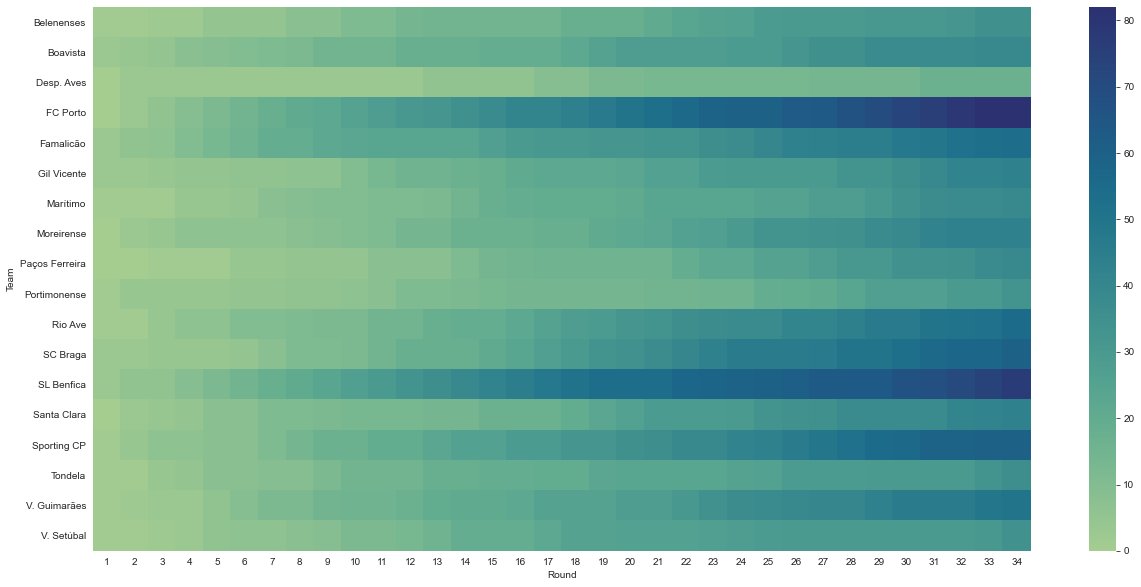

In [14]:
bcr_df = df_teamwise.copy()

# Cumulative points
bcr_df['TotalPoints'] = bcr_df.groupby('Team')['Points'].transform(pd.Series.cumsum).values

bcr_df = bcr_df[['Team', 'Round', 'TotalPoints']]
bcr_df = bcr_df.drop_duplicates()
bcr_df = bcr_df.reset_index().pivot_table(values='TotalPoints', index='Round', columns='Team', aggfunc='max')

bcr_df.to_csv(join(Dash_Path, 'bcr_df.csv'))

fig = plt.figure(figsize = (21, 10))

sns.heatmap(bcr_df.T, cmap = 'crest')

### 1.2. Using Bar Chart Races

In [15]:
bcr.bar_chart_race(
    df = bcr_df,
    filename = None,
    bar_size = .85,
    period_label = {'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    figsize = (7, 4),
    cmap = 'dark12',
    title = 'Liga NOS Classification, ' + Season + ' Season',
    shared_fontdict = {'family' : 'Segoe UI', 'color' : '.1'}
)  

## 2. Pre-Assessment Dashboard, using Dash and Plotly

### 2.1. Exporting tables for Dash App
Since we will be developing the app in another separate script, in order to avoid computing everything again, needed dataframes will be exported to disk to be again uploaded in the Dash app.

In [16]:
# Append all seasons classification
df_class = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_class_int = compute_final_table(table_teamwise(table_preprocessing(season)))
    df_class_int['SeasonOrder'] = season_order
    
    df_class = df_class.append(df_class_int, ignore_index = True)

df_class.to_csv(join(Dash_Path, 'df_class.csv'))
df_class.head()

,Season,Team,Games,Won,Drawn,Lost,Points,GoalsScored,GoalsConceded,GoalsDifference,A,2A,VE,SeasonOrder
0,2021,Sporting CP,31,24,7,0,79,56,15,41,74,2,1,27
1,2021,FC Porto,32,22,8,2,74,67,29,38,51,3,1,27
2,2021,SL Benfica,31,20,7,4,67,59,22,37,64,0,0,27
3,2021,SC Braga,32,18,6,8,60,51,32,19,55,1,4,27
4,2021,Paços Ferreira,32,14,8,10,50,37,37,0,58,0,2,27


In [17]:
# Append all seasons round cumulative classification
df_bcr = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_bcr_int = table_teamwise(table_preprocessing(season))

    # Cumulative points
    df_bcr_int['TotalPoints'] = df_bcr_int.groupby('Team')['Points'].transform(pd.Series.cumsum).values

    df_bcr_int = df_bcr_int[['Team', 'Round', 'TotalPoints']]
    df_bcr_int = df_bcr_int.drop_duplicates()
    
    df_bcr_int.insert(0, 'Season', season)
    df_bcr_int.insert(1, 'SeasonOrder', season_order)

    # Computing the ranks for each round and storing it in Position
    df_bcr_int2 = pd.DataFrame()
    for game_round in df_bcr_int['Round'].unique():
        
        df_bcr_int3 = df_bcr_int[df_bcr_int['Round'] == game_round].sort_values(by = 'TotalPoints', ascending = False)
        df_bcr_int3['Position'] = [i for i in range(1, len(df_bcr_int3) + 1)]
        df_bcr_int2 = df_bcr_int2.append(df_bcr_int3, ignore_index = True)
        
    df_bcr = df_bcr.append(df_bcr_int2, ignore_index = True)
    
df_bcr.to_csv(join(Dash_Path, 'df_bcr.csv'))
df_bcr.head()

,Season,SeasonOrder,Team,Round,TotalPoints,Position
0,2021,27,Sporting CP,1,3,1
1,2021,27,Belenenses,1,3,2
2,2021,27,FC Porto,1,3,3
3,2021,27,Santa Clara,1,3,4
4,2021,27,SL Benfica,1,3,5


In [18]:
# Append all seasons games with its score
df_games = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_games_int = table_preprocessing(season)
    df_games_int['Match'] = df_games_int['HomeTeam'] + " " + df_games_int['H_Goals'].astype(str) + " - " + df_games_int['A_Goals'].astype(str) + " " + df_games_int['AwayTeam']
    
    df_games_int = df_games_int[['Round', 'Date', 'Match', 'B365H', 'B365D', 'B365A']]
    
    df_games_int.insert(0, 'Season', season)    
    df_games_int.insert(1, 'SeasonOrder', season_order)
    df_games = df_games.append(df_games_int, ignore_index = True)

df_games.to_csv(join(Dash_Path, 'df_games.csv'))
df_games.head()

,Season,SeasonOrder,Round,Date,Match,B365H,B365D,B365A
0,2021,27,1,2020-09-18,Famalicão 1 - 5 SL Benfica,7.50,5.00,1.36
1,2021,27,1,2020-09-18,V. Guimarães 0 - 1 Belenenses,1.45,4.33,7.00
2,2021,27,1,2020-09-19,Nacional 3 - 3 Boavista,2.55,3.10,2.87
3,2021,27,1,2020-09-19,FC Porto 3 - 1 SC Braga,1.61,4.00,5.00
4,2021,27,1,2020-09-20,Santa Clara 2 - 0 Marítimo,2.10,3.20,3.60


# III. MYTH BUSTERS -----------------------------------------------------------

## Myth 1: There are only three major teams in Portugal

Since the myth appears to have started its diffusion in the seventies, we will here perform a comparative analysis between two decades: the 70's (1970/71 to 1979/80) and the 10's (2010/11 to 2019/20)

for each analysis we will apply the K Means clustering method to visualize the teams that have really distinct performances.
For that we will use the most important stats from the matches played such as : 
 - Results Won and Losses
 - Goals Scored and conceded
 - Season Points

### The 70's

Dataframe from each season with the chosen features

In [19]:
path_70s = Int_Path + r'\classificacao70s.csv'
df_70s = pd.read_csv(path_70s, index_col = 1)

rename = {"Unnamed: 2": "Team", 
          "Temporada": "Season",
          "P":"Points",
          "V":"Results_Won",
          'D':"Results_Loss",
          'GM':'GoalsScored',
          'GS':'GoalsConceded'}

df_70s.rename(columns = rename, inplace=True)

df_70s['Team'] = df_70s['Team'].replace(dict_team_name)

df_70s = df_70s[['Season', 'Team', 'Results_Won', 'Results_Loss', 'GoalsScored', 'GoalsConceded', 'Points']].reset_index(drop = True)
df_70s.head()

,Season,Team,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points
0,70/71,SL Benfica,18.0,3.0,62.0,17.0,41.0
1,70/71,Sporting CP,16.0,4.0,45.0,14.0,38.0
2,70/71,FC Porto,16.0,5.0,44.0,21.0,37.0
3,70/71,V. Setúbal,15.0,7.0,51.0,16.0,34.0
4,70/71,Académica,13.0,6.0,38.0,24.0,33.0


Grouping by team and summing up the values of each feature to get a 'decade' overview

In [20]:
df_70s_tw = df_70s.groupby('Team').sum()
df_70s_tw.head()

,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points
Team,,,,,
Académica,72.0,110.0,251.0,316.0,198.0
Académico de Viseu,5.0,24.0,13.0,75.0,11.0
Atlético CP,34.0,78.0,149.0,290.0,106.0
Barreirense,39.0,70.0,141.0,228.0,115.0
Beira-Mar,43.0,88.0,195.0,327.0,135.0


 

 ------------ Scaled Seventies Dataframe ------------------------------------------------------------------------------------------------- 

   Results_Won  Results_Loss  GoalsScored  GoalsConceded    Points
0     0.362241      2.009629     0.360125       1.324896  0.474396
1    -0.931017     -1.034906    -1.011232      -1.179417 -1.058646
2    -0.371249      0.876779    -0.227599       1.054721 -0.279828
3    -0.274737      0.593566    -0.273695       0.410458 -0.206045
4    -0.197528      1.230794     0.037453       1.439200 -0.042084
 

 ------------------------------------------------------------------------------------------------------------------------------------------ 



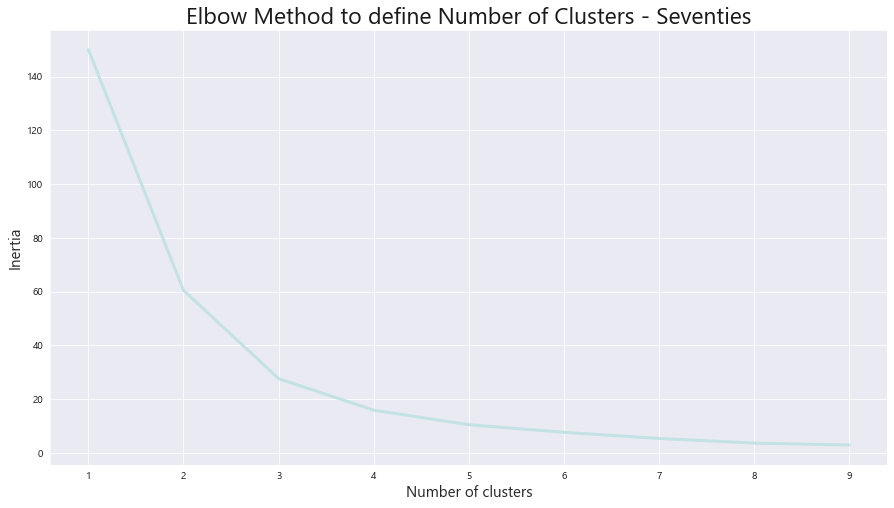

In [21]:
def scaling(dataframe):

    dataframe_scaled = StandardScaler().fit_transform(dataframe)
    dataframe_scaled = pd.DataFrame(dataframe_scaled, columns = list(dataframe.columns[0:5]))
    
    return dataframe_scaled
    
def elbow_method(period, dataframe_scaled):
    
    #Elbow Method
    ks = range(1, 10)
    inertias = []

    for k in ks:
        modelKMeansMnt = KMeans(n_clusters = k)

        modelKMeansMnt.fit(dataframe_scaled)

        inertias.append(modelKMeansMnt.inertia_)

    # Plotting the results
    plt.figure(figsize = (15,8))
    plt.title('Elbow Method to define Number of Clusters - ' + period, size = 23)
    plt.plot(ks, inertias, linewidth = 3)
    plt.xlabel('Number of clusters', size = 15)
    plt.ylabel('Inertia', size = 15)
    plt.xticks(ks)
    plt.show()

    

period = 'Seventies'

df_scaled_70s = scaling(df_70s_tw)
    
print(' \n\n ------------ Scaled', period, 'Dataframe ------------------------------------------------------------------------------------------------- \n')
print(df_scaled_70s.head())
print(' \n\n ------------------------------------------------------------------------------------------------------------------------------------------ \n')
    
elbow_method(period, df_scaled_70s)

Using the elbow method for helping define the ideal number of clusters, it is visible the elbow on 3 clusters. However, we know that we can best define the clubs with 4 clusters to separate them into Small, Low Intermediate, High Intermediate and Big, being the High Intermediate level clubs the ones who dispute the top positions below the podium, and the Low Intermediate level the ones who can manage the presence in the first division.

In [22]:
def fitting_k_means(dataframe, dataframe_scaled, n_clusters):

    #Fitting KMeans
    KMeans_k = KMeans(n_clusters = n_clusters, random_state = 100)
    KMeans_k.fit(dataframe_scaled)
    dataframe['label'] = KMeans_k.labels_
    
fitting_k_means(df_70s_tw, df_scaled_70s, 4)
df_70s_tw.head()
# First we need to run the cells above (and comment the ones bellow, to check if the labels are correct)

,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points,label
Team,,,,,,
Académica,72.0,110.0,251.0,316.0,198.0,1
Académico de Viseu,5.0,24.0,13.0,75.0,11.0,0
Atlético CP,34.0,78.0,149.0,290.0,106.0,2
Barreirense,39.0,70.0,141.0,228.0,115.0,2
Beira-Mar,43.0,88.0,195.0,327.0,135.0,2


In [23]:
df_70s_tw['label'] = df_70s_tw['label'].replace({0: 'Small',
                                                 1: 'High Intermediate',
                                                 2: 'Low Intermediate',
                                                 3: 'Big'})


print(' \n\n ------------ Clusters Formed and their mean values ------------------------------------------------------------------------------------------------- \n')
print(df_70s_tw.groupby(['label']).mean().transpose())
print(' \n\n ------------------------------------------------------------------------------------------------------------------------------------------')

for team_size in df_70s_tw['label'].unique():

    print(team_size, 'Teams:', ', '.join(df_70s_tw.loc[df_70s_tw['label'] == team_size].reset_index()['Team'].unique()))
    print(' ------------------------------------------------------------------------------------------------------------------------------------------ \n')

 

 ------------ Clusters Formed and their mean values ------------------------------------------------------------------------------------------------- 

label                 Big  High Intermediate  Low Intermediate       Small
Results_Won    173.000000              101.8         44.000000   17.400000
Results_Loss    39.000000               91.2         79.714286   31.066667
GoalsScored    582.666667              355.6        169.285714   62.933333
GoalsConceded  205.333333              309.4        276.428571  103.800000
Points         400.000000              270.6        129.142857   49.800000
 

 ------------------------------------------------------------------------------------------------------------------------------------------
High Intermediate Teams: Académica, Belenenses, Boavista, V. Guimarães, V. Setúbal
 ------------------------------------------------------------------------------------------------------------------------------------------ 

Small Teams: Académico de V

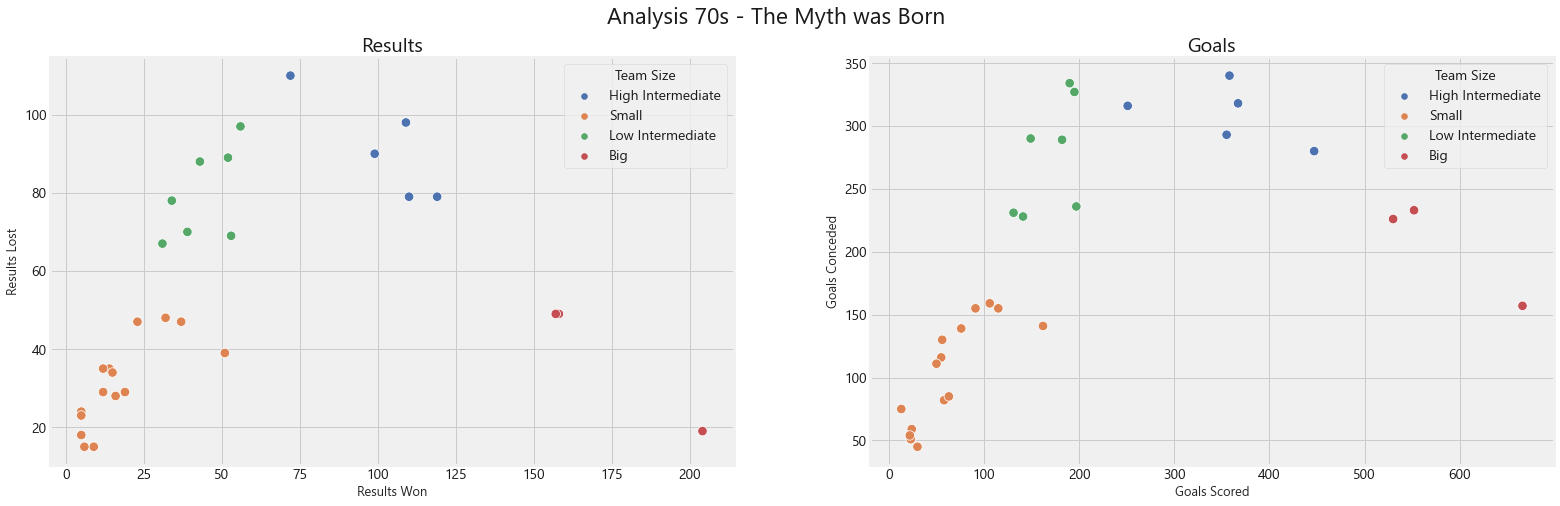

In [24]:
def plot_clusters(dataframe, title, style, figsize):
    
    plt.style.use(style)
    fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = figsize)

    sns.scatterplot(dataframe['Results_Won'],
                    dataframe['Results_Loss'],
                    hue = dataframe['label'], 
                    s = 90,
                    palette = 'deep',
                    ax = ax[0])
    
    sns.scatterplot(dataframe['GoalsScored'],
                    dataframe['GoalsConceded'],
                    hue = dataframe['label'], 
                    s = 90, 
                    palette='deep',
                    ax = ax[1])

    plt.suptitle(title, size = 23)
    ax[0].set_title('Results', size = 20)
    ax[1].set_title('Goals', size = 20)
    ax[0].set_xlabel('Results Won', size = 13)
    ax[0].set_ylabel('Results Lost', size = 13)
    ax[1].set_xlabel('Goals Scored', size = 13)
    ax[1].set_ylabel('Goals Conceded', size = 13)
    ax[0].legend(title = 'Team Size', fontsize = 14)
    ax[1].legend(title = 'Team Size', fontsize = 14)
    
plot_clusters(df_70s_tw, 'Analysis 70s - The Myth was Born', 'fivethirtyeight', (24,7))

It is clearly visible the distance in performance from the "Big" clubes to the remaining, both in match results and in goals performance. Although having 4 other mid teams distanced from the remaining, they are still far away from a Big performance.

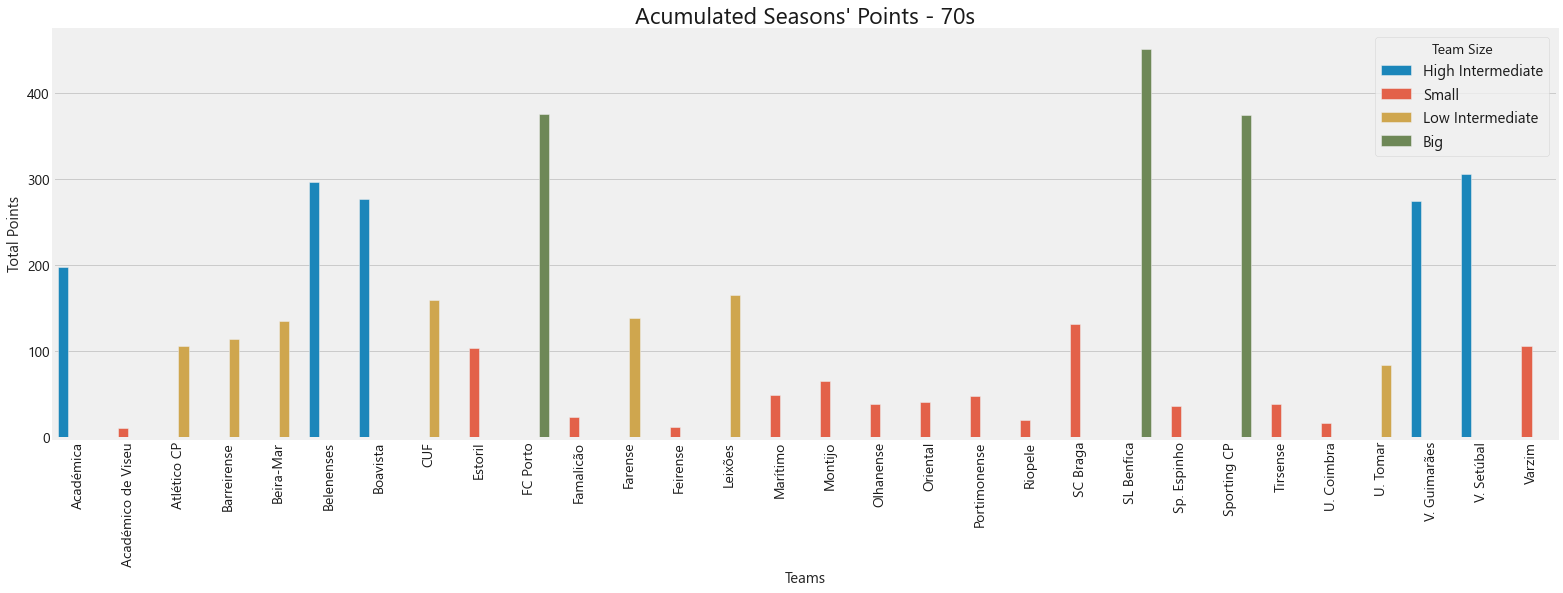

In [25]:
def plot_points(dataframe, title, style, figsize):

    plt.style.use(style)
    plt.figure(figsize = figsize)

    sns.barplot(data = dataframe,
                x = dataframe.index,
                y = dataframe.Points,
                hue = dataframe.label)
    
    plt.title(title, size = 23)
    plt.ylabel('Total Points', size = 15)
    plt.xlabel('Teams', size = 15)
    plt.xticks(rotation = 45)

    plt.legend(title = 'Team Size', fontsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

plot_points(df_70s_tw, "Acumulated Seasons' Points - 70s", 'fivethirtyeight', (24,7))

### The 10's

Now we will use the 10s decade LigaNOS stats to get a glance of the football that is being played nowadays. Furthermore, we want to visualize the distance between the teams, and if it still stands the distance from the old times.

In [26]:
list_10s = ['1011', '1112', '1213', '1314', '1415', '1516', '1617', '1718', '1819']

df_10s = df_class[df_class['Season'].isin(list_10s)] \
                 .reset_index(drop = True) \
                 [['Season', 'Team', 'Won', 'Lost', 'GoalsScored', 'GoalsConceded', 'Points']] \
                 .rename(columns = {'Won': 'Results_Won', 'Lost': 'Results_Loss'})
df_10s.head()

,Season,Team,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points
0,1819,SL Benfica,28,3,103,31,87
1,1819,FC Porto,27,3,74,20,85
2,1819,Sporting CP,23,6,72,33,74
3,1819,SC Braga,21,9,56,37,67
4,1819,V. Guimarães,15,12,46,34,52


In [27]:
df_10s_tw = df_10s.groupby('Team').sum()
df_10s_tw.head()

,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points
Team,,,,,
Académica,38,86,175,272,178
Arouca,37,61,134,187,145
Beira-Mar,20,45,93,129,85
Belenenses,56,79,199,276,233
Boavista,53,77,153,211,199


 

 ------------ Scaled Tens Dataframe ------------------------------------------------------------------------------------------------- 

   Results_Won  Results_Loss  GoalsScored  GoalsConceded    Points
0    -0.451026      0.617712    -0.262220       0.446922 -0.303979
1    -0.467710     -0.118869    -0.492655      -0.307642 -0.474699
2    -0.751327     -0.590281    -0.723091      -0.822521 -0.785100
3    -0.150726      0.411469    -0.127331       0.482431 -0.019445
4    -0.200776      0.352543    -0.385868      -0.094588 -0.195338
 

 ------------------------------------------------------------------------------------------------------------------------------------------ 



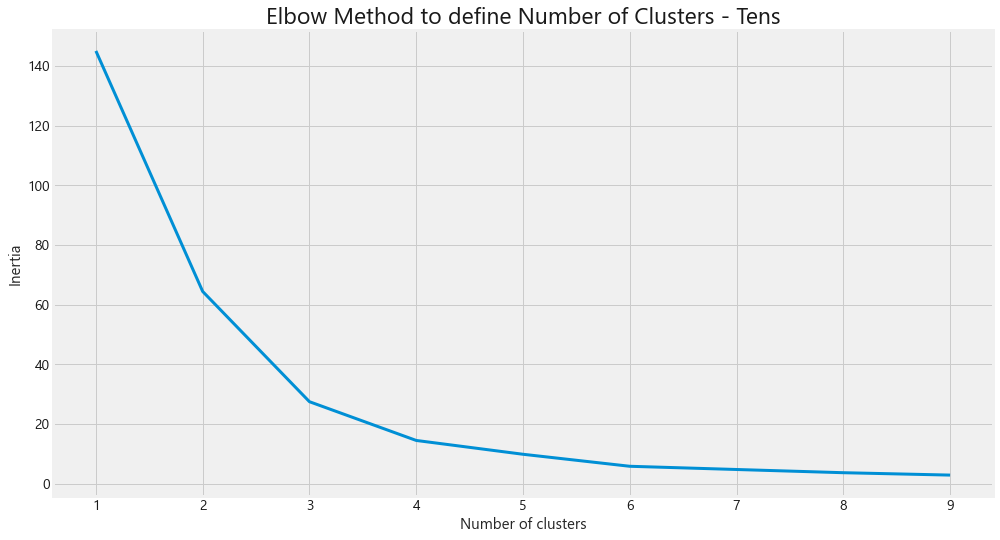

In [28]:
period = 'Tens'

df_scaled_10s = scaling(df_10s_tw)
    
print(' \n\n ------------ Scaled', period, 'Dataframe ------------------------------------------------------------------------------------------------- \n')
print(df_scaled_10s.head())
print(' \n\n ------------------------------------------------------------------------------------------------------------------------------------------ \n')
    
elbow_method(period, df_scaled_10s)

In [29]:
fitting_k_means(df_10s_tw, df_scaled_10s, 4)
df_10s_tw.head()

,Results_Won,Results_Loss,GoalsScored,GoalsConceded,Points,label
Team,,,,,,
Académica,38,86,175,272,178,3
Arouca,37,61,134,187,145,3
Beira-Mar,20,45,93,129,85,0
Belenenses,56,79,199,276,233,3
Boavista,53,77,153,211,199,3


In [30]:
df_10s_tw['label'] = df_10s_tw['label'].replace({0: 'Small',
                                                 1: 'High Intermediate',
                                                 2: 'Big',
                                                 3: 'Low Intermediate'})


print(' \n\n ------------ Clusters Formed and their mean values ------------------------------------------------------------------------------------------------- \n')
print(df_10s_tw.groupby(['label']).mean().transpose())
print(' \n\n ------------------------------------------------------------------------------------------------------------------------------------------')

for team_size in df_10s_tw['label'].unique():

    print(team_size, 'Teams:', ', '.join(df_10s_tw.loc[df_10s_tw['label'] == team_size].reset_index()['Team'].unique()))
    print(' ------------------------------------------------------------------------------------------------------------------------------------------ \n')

 

 ------------ Clusters Formed and their mean values ------------------------------------------------------------------------------------------------- 

label                 Big  High Intermediate  Low Intermediate  Small
Results_Won    206.333333         100.285714         44.555556   16.4
Results_Loss    33.333333         110.571429         75.555556   33.2
GoalsScored    618.333333         345.714286        162.888889   68.7
GoalsConceded  211.666667         380.428571        234.111111  102.3
Points         669.333333         370.285714        177.777778   66.6
 

 ------------------------------------------------------------------------------------------------------------------------------------------
Low Intermediate Teams: Académica, Arouca, Belenenses, Boavista, Estoril, Feirense, Gil Vicente, Moreirense, Tondela
 ------------------------------------------------------------------------------------------------------------------------------------------ 

Small Teams: Beira-Mar,

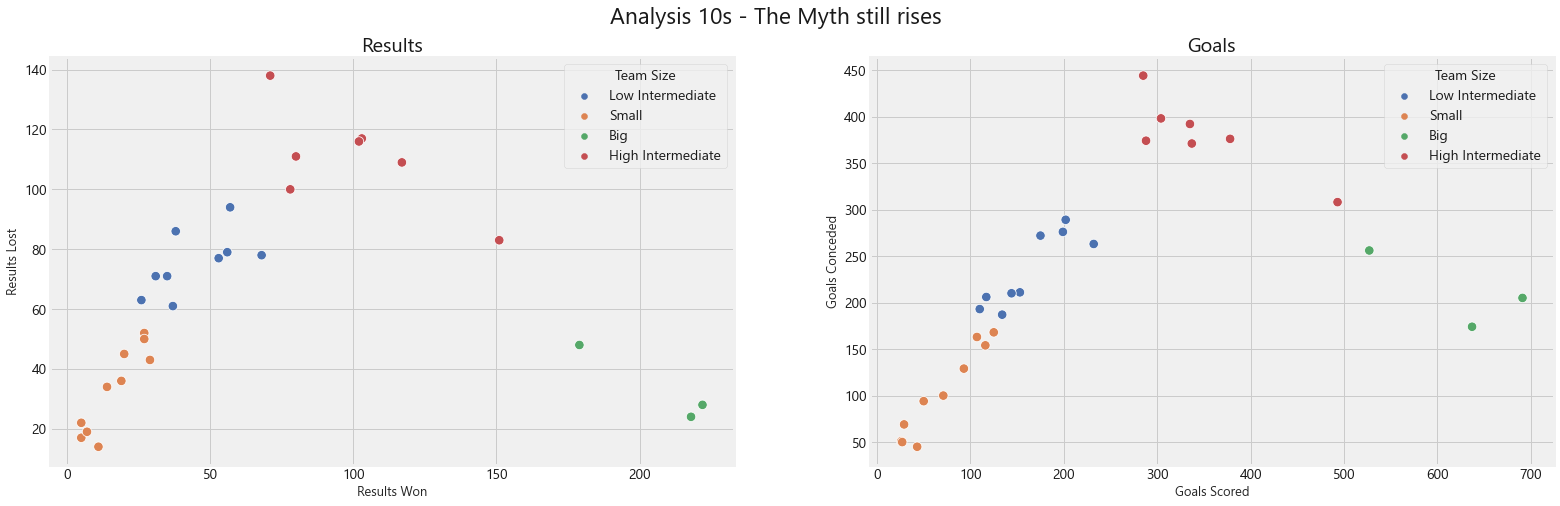

In [31]:
plot_clusters(df_10s_tw, 'Analysis 10s - The Myth still rises', 'fivethirtyeight', (24,7))

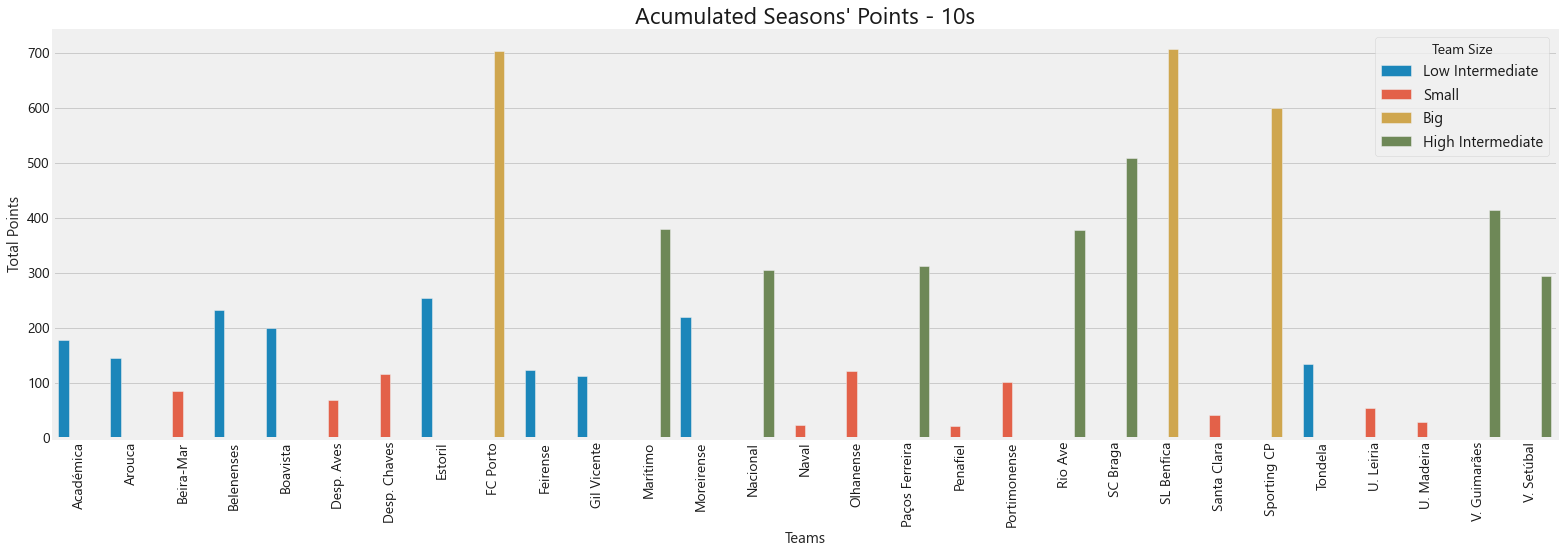

In [32]:
plot_points(df_10s_tw, "Acumulated Seasons' Points - 10s", 'fivethirtyeight', (24,7))

The results shows that the we still have three big clubs, clearly standing out from the remaining teams both in results and in goals performance, being true that no other has been able to interrupt the usual champions in the recent years - it is visible we have a fourth big club coming in the way - that is SC Braga - a 'small' team in the 70s, showing a great development in their sports performance being now a club clearly far from the high intermediate, close to the big ones.

## Myth 2: FC Porto is the most undisciplined team 

Since the number of fouls measures a team aggressiveness, more than its undiscipline, we've decided not to scrap this data for seasons before 2017/18 (from there beyond, we have this data in the original datasets). Therefore, our analysis will be based in yellow and red cards only.

Clearly, it's not an easy task to objectively measure "how much undiscipline represents a yellow card, as opposed to a red card, and even two yellow cards (which sends off the player too). We've decided to overcome this by creating a score system:
* 1 yellow card - 1 point
* 2 yellow cards - 2.5 points
* 1 red card - 5 points

In [33]:
team = 'FC Porto'

df_myth2 = df_cards.copy()

df_myth2['SeasonFirstYear'] = df_myth2['Season'].apply(lambda x: '19' + x[:2] if int(x[:2]) > 50 else '20' + x[:2]).astype(int)
df_myth2['SeasonExtended'] = df_myth2['SeasonFirstYear'].map(lambda x: str(x) + "/" + str(x + 1)[2:])
 
firstseason_year = 1994 # Change this value to see the results for fewer seasons
firstseason = df_myth2.loc[df_myth2['SeasonFirstYear'] == firstseason_year]['Season'].values[0]

df_myth2 = df_myth2.loc[df_myth2['SeasonFirstYear'] >= firstseason_year].reset_index(drop = True)

In [34]:
# Computing the score system
yellow_score = 1
doubleyellow_score = 2.5
red_score = 5

df_myth2['CardScore'] = yellow_score * df_myth2['A'] + doubleyellow_score * df_myth2['2A'] + red_score * df_myth2['VE']

# Computing the average CardScore by season
df_cardscore_byseason = pd.DataFrame(df_myth2.groupby(['Season', 'SeasonFirstYear'])['CardScore'].mean())

#FC Porto's points per season
cardscore_fcporto = df_myth2.loc[df_myth2['Team'] == 'FC Porto'] \
                            .rename(columns = {'CardScore': 'CardScore_FCPorto'})


cardscore_fcporto = cardscore_fcporto[['Season', 'SeasonFirstYear', 'SeasonExtended', 'Team', 'A', '2A', 'VE', 'CardScore_FCPorto']]

In [35]:
#Comparing FC Porto's cardscore with the average, by season
comparison_fcporto = df_cardscore_byseason.merge(cardscore_fcporto, on = 'Season') \
                                          .drop(['Team', 'A', '2A', 'VE'], axis = 1)

comparison_fcporto['Difference'] = comparison_fcporto['CardScore_FCPorto'] - comparison_fcporto['CardScore']
comparison_fcporto = comparison_fcporto.round(1) \
                                       .sort_values(by = ['SeasonFirstYear']) \
                                       .reset_index(drop = True) \
                                       [['Season', 'SeasonFirstYear', 'SeasonExtended', 'CardScore', 'CardScore_FCPorto', 'Difference']]

comparison_fcporto.head()

,Season,SeasonFirstYear,SeasonExtended,CardScore,CardScore_FCPorto,Difference
0,9495,1994,1994/95,111.9,104.5,-7.4
1,9596,1995,1995/96,113.9,89.5,-24.4
2,9697,1996,1996/97,131.1,113.5,-17.6
3,9798,1997,1997/98,124.3,124.0,-0.3
4,9899,1998,1998/99,130.1,104.0,-26.1


In [36]:
cardscore_fcporto_avg = round(comparison_fcporto['CardScore_FCPorto'].mean(), 1)
cardscore_total_avg = round(comparison_fcporto['CardScore'].mean(), 1)
cardscore_diff_avg = round(comparison_fcporto['Difference'].mean(), 1)

print(team, "has an average card score (since Season", firstseason + ") of", cardscore_fcporto_avg)
print("Meanwhile, the overall score for all teams is of", cardscore_total_avg, "\n")
print("This means that", team, "has a cardscore difference of", cardscore_diff_avg)

FC Porto has an average card score (since Season 9495) of 90.6
Meanwhile, the overall score for all teams is of 109.1 

This means that FC Porto has a cardscore difference of -18.5


In [37]:
comparison_fcporto[comparison_fcporto['Difference'] > 0]

,Season,SeasonFirstYear,SeasonExtended,CardScore,CardScore_FCPorto,Difference
8,0203,2002,2002/03,114.5,117.5,3.0
9,0304,2003,2003/04,112.3,112.5,0.2
10,0405,2004,2004/05,119.6,151.0,31.4


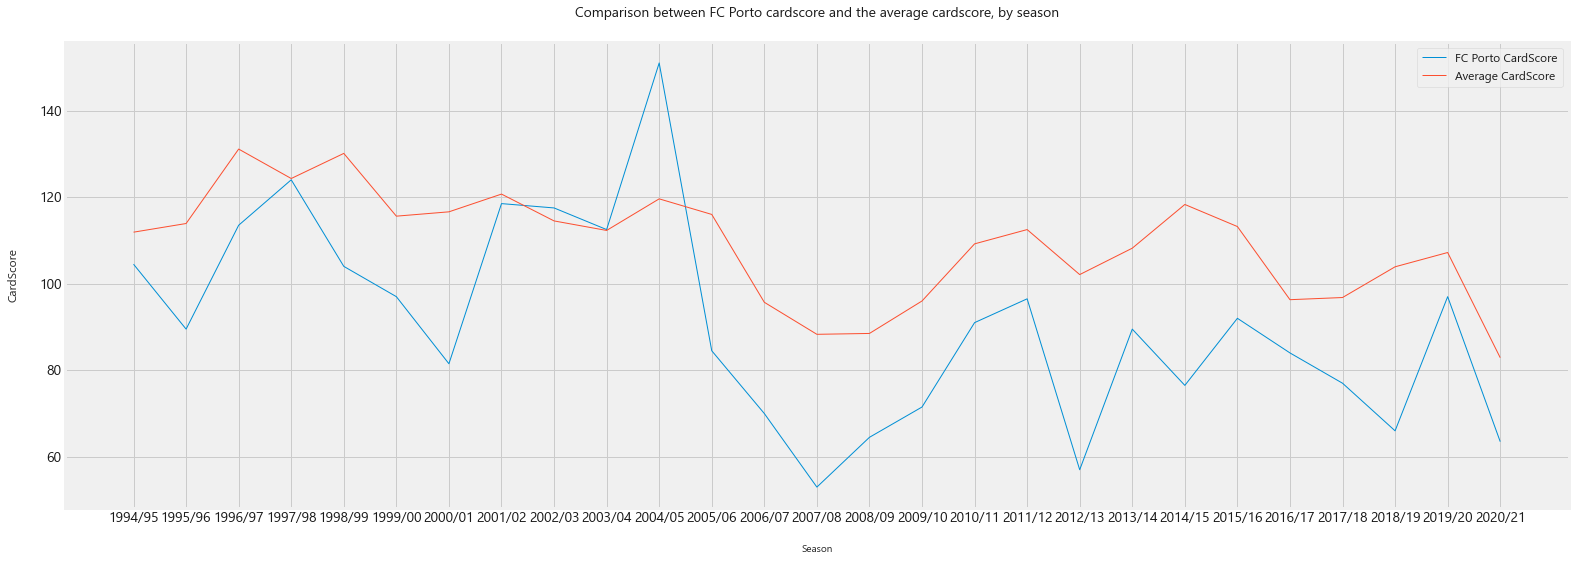

In [38]:
# Let's visualize it
figure = plt.figure(figsize = (24,8))

plt.style.use('fivethirtyeight')
rc('font',**{'family':'Segoe UI'})

plt.title('Comparison between FC Porto cardscore and the average cardscore, by season', size = 14, y = 1.04)

labels = ['FC Porto CardScore', 'Average CardScore']

plt.ylabel('CardScore', labelpad = 20, fontsize = 12)
plt.xlabel('Season', labelpad = 20, fontsize = 10)
sns.lineplot(data = comparison_fcporto, x = 'SeasonExtended', y = 'CardScore_FCPorto', palette = 'deep', linewidth = 1)
sns.lineplot(data = comparison_fcporto, x = 'SeasonExtended', y = 'CardScore', palette = 'deep', linewidth = 1)

plt.legend(labels, loc = "upper right", prop = {'size': 12})

plt.show()

The chart and the average results show us that, clearly, **FC Porto IS NOT the most undisciplined team in the championship**, having had a lower card score than the season averages for all seasons except for 3:
* 2002/03
* 2003/04
* 2004/05

#### Therefore, what team fits in the description of most undisciplined one?

Let's first see it for the last finished season, 2019/20:

In [39]:
# Identifying the Top 10 of Undisciplined Teams for season 2019/20

df_myth2_1920 = df_myth2.loc[df_myth2['Season'] == '1920'] \
                        .sort_values(by = 'CardScore', ascending=False) \
                        .reset_index(drop = True) \
                        [['SeasonExtended', 'Team', 'A', '2A', 'VE', 'CardScore']]

print(' \n\n ------ Top 10 Undisciplined Teams - Season', df_myth2_1920['SeasonExtended'].values[0], '----- \n')

print(df_myth2_1920.head(10))

print(' \n\n -------------------------------------------------------- \n')

 

 ------ Top 10 Undisciplined Teams - Season 2019/20 ----- 

  SeasonExtended            Team    A  2A  VE  CardScore
0        2019/20       Famalicão   99   3   8      146.5
1        2019/20        Boavista  111   3   4      138.5
2        2019/20  Paços Ferreira  112   4   2      132.0
3        2019/20      V. Setúbal   99   3   4      126.5
4        2019/20        Marítimo   98   1   5      125.5
5        2019/20      Desp. Aves   94   4   3      119.0
6        2019/20        SC Braga   91   2   4      116.0
7        2019/20      Belenenses   96   3   1      108.5
8        2019/20         Rio Ave   71   2   5      101.0
9        2019/20     Sporting CP   91   3   0       98.5
 

 -------------------------------------------------------- 



In 2019/20, Famalicão was by far the most undisciplined team, with 99 yellow cards, and a total of 11 red cards (including double yellow), which translates into a score of 146.5. **Let's see it for all other seasons**:

In [40]:
top_cardscore = df_myth2.groupby(['Season', 'Team']) \
                        .sum() \
                        .reset_index() \
                        .sort_values(by = ['SeasonFirstYear', 'CardScore'], ascending = False) \
                        .reset_index(drop = True) \
                        [['Season', 'Team', 'CardScore', 'A', '2A', 'VE']]

top_cardscore_max_values = top_cardscore.groupby('Season') \
                                        .max() \
                                        .reset_index() \
                                        [['Season', 'CardScore']]

top_cardscore_max_teams = top_cardscore_max_values.merge(df_myth2[['Season', 'SeasonFirstYear', 'SeasonExtended', 'Team', 'CardScore', 'A', '2A', 'VE']],
                                                         on = ['Season', 'CardScore']) \
                                                  .sort_values(by = 'SeasonFirstYear') \
                                                  .reset_index(drop = True) \
                                                  [['SeasonExtended', 'Team', 'CardScore', 'A', '2A', 'VE']]
                                             
def highlight_col(top_cardscore_max_teams):
    """ Function to color top_cardscore_max_teams
    with blue when FC Porto is on top of undiscipline
    """
    df_color = top_cardscore_max_teams.copy()
    mask = df_color['Team'] == 'FC Porto'
    df_color.loc[mask, :] = 'background-color: #ADD8E6'
    df_color.loc[~mask,:] = 'background-color: ""'
    return df_color

top_cardscore_max_teams.style.apply(highlight_col, axis = None)

,SeasonExtended,Team,CardScore,A,2A,VE
0,1994/95,U. Madeira,148.000000,108,6,5
1,1995/96,Leça,186.000000,116,12,8
2,1996/97,U. Leiria,178.500000,121,11,6
3,1997/98,Belenenses,160.000000,120,8,4
4,1998/99,Alverca,164.500000,112,13,4
5,1999/00,Campomaiorense,166.500000,119,13,3
6,2000/01,Campomaiorense,153.000000,128,8,1
7,2001/02,Paços Ferreira,148.500000,106,7,5
8,2002/03,V. Guimarães,129.000000,99,2,5
9,2003/04,Boavista,134.500000,107,1,5


Indeed, no team stands out for being consistently on top of undiscipline. However, we do note that **FCPorto is the only one among the 3 big clubs** (oh wait, we just proved above they are in fact 4 !) **ranking 1st in a single season**.

Finally, let's compute a final ranking of undiscipline. Since we've seen in Myth 1 that things change quikly in football, let's do this work for the last decade only (2011/12 till 2019/20). Anyway, since some teams did not play in the first division in all seasons, we need first to normalize the CardScore per game played so we can make fair comparisons:

In [41]:
myth2_year_to_assess = 2011

df_myth2_normalized = df_myth2[df_myth2['SeasonFirstYear'] >= myth2_year_to_assess]

# Getting the number of games from df_class
df_myth2_normalized = df_myth2_normalized.merge(df_class[['Season', 'Team', 'Games']], on = ['Season', 'Team'])

df_myth2_seasonsperteam = df_myth2_normalized.groupby('Team').count().rename(columns = {'Season': 'NrSeasons'})[['NrSeasons']].reset_index()

df_myth2_normalized = df_myth2_normalized.groupby(['Team']) \
                                         .sum() \
                                         .reset_index() \
                                         [['Team', 'Games', 'CardScore']]

df_myth2_normalized['CardScore_Norm'] = df_myth2_normalized['CardScore'] / df_myth2_normalized['Games']
df_myth2_normalized = df_myth2_normalized.merge(df_myth2_seasonsperteam).sort_values(by = 'CardScore_Norm', ascending = False).reset_index(drop = True)[['Team', 'NrSeasons', 'CardScore_Norm']]
df_myth2_normalized

,Team,NrSeasons,CardScore_Norm
0,Penafiel,1,4.338235
1,Olhanense,3,3.977778
2,Beira-Mar,2,3.916667
3,Famalicão,2,3.730769
4,Feirense,4,3.719697
5,V. Setúbal,9,3.649660
6,Marítimo,10,3.575153
7,Académica,5,3.556962
8,Boavista,7,3.538298
9,Arouca,4,3.462121


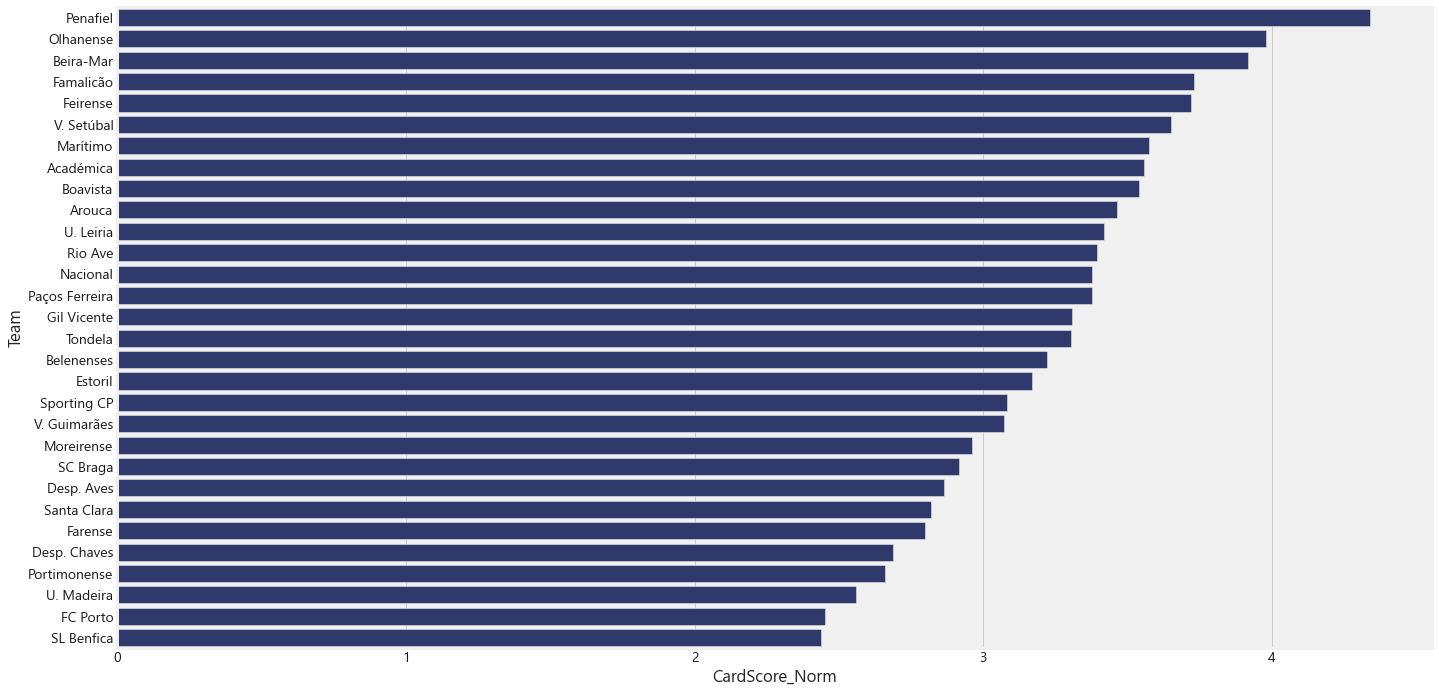

In [42]:
fig = plt.figure(figsize = (21, 11))

sns.barplot(x = df_myth2_normalized['CardScore_Norm'], y = df_myth2_normalized['Team'], color = '#253275')

plt.savefig(r'C:\Users\pedro\OneDrive\Ambiente de Trabalho\Nova IMS\Programming for Data Science\Projeto\ProjetoProgramming\MitoPortoCardScore.png')

We conclude that teams with less seasons played are more undisciplined, which may indicate that the worse the team, the more undisciplined it is. This is confirmed by the fact that FC Porto and Benfica are in the last places of undiscipline. WAIT, WHAT? FC Porto is THE LESS undisciplined team in the champioship after SL Benfica !

### MYTH BUSTED !

## Myth 3: Sporting CP is not playing better than in past seasons

In [53]:
df_stats2021 = df2021.describe()
df_stats1920 = df1920.describe()

The variables in the dataset had to be scaled for a better understanting on the ones that impacted the most in the TotalPoints for each team.

In [54]:
min_max_scaler = MinMaxScaler()

columns_int = df1920.drop(columns = ['Team']).columns

df1920[columns_int] = min_max_scaler.fit_transform(df1920[columns_int])
df2021[columns_int] = min_max_scaler.fit_transform(df2021[columns_int])

Correlation for each season was used as a correction factor.

In [55]:
df1920.set_index('Unnamed: 0', inplace=True)
df2021.set_index('Unnamed: 0', inplace=True)

df_corr1920 = df1920[df1920.columns[1:]].corr()['Points'][:]
df_corr2021 = df2021[df2021.columns[1:]].corr()['Points'][:]

KeyError: "None of ['Unnamed: 0'] are in the columns"

In [ ]:
df_final2021 = pd.DataFrame()
rangedf = len(df_corr2021) - 1
ranking = []
score = 0
iterator = 0

for i in range(2,20):
    ranking = []
    for k in range(18):
        ranking.append(df2021.iloc[k,i] * df_corr2021[i-1])
    col_name = str(iterator)
    df_final2021.loc[:, col_name] = ranking 
    iterator += 1
    
df_final1920 = pd.DataFrame()
rangedf = len(df_corr1920) - 1
ranking = []
score = 0
iterator = 0

for i in range(2,20):
    ranking = []
    for k in range(18):
        ranking.append(df1920.iloc[k,i] * df_corr1920[i-1])
    col_name = str(iterator)
    df_final1920.loc[:, col_name] = ranking 
    iterator += 1

In [ ]:
df_final1920.loc[:,'Total'] = df_final1920.sum(axis=1)
df_final1920["Team"] = df1920["Team"].to_numpy()
df_final2021.loc[:,'Total'] = df_final2021.sum(axis=1)
df_final2021["Team"] = df2021["Team"].to_numpy()

In order to distinguish the teams the following code was added:

In [56]:
colors2021 = []
index2021 = []
for i in range(len(df_final2021)):
    if(df_final2021.loc[i, "Team"] == 'Sporting CP'):
        colors2021.append('green')
    elif(df_final2021.loc[i, "Team"] == 'SL Benfica'):
        colors2021.append('red')
    elif(df_final2021.loc[i, "Team"] == 'FC Porto'):
        colors2021.append('skyblue')
    elif(df_final2021.loc[i, "Team"] == 'SC Braga'):
        colors2021.append('lightcoral')
    else:
        colors2021.append('lightgrey') 
    index2021.append(i)

df_final2021['index'] = index2021

In [57]:
colors1920 = []
index1920 = []
for i in range(len(df_final1920)):
    if(df_final1920.loc[i, "Team"] == 'Sporting CP'):
        colors1920.append('green')
    elif(df_final1920.loc[i, "Team"] == 'SL Benfica'):
        colors1920.append('red')
    elif(df_final1920.loc[i, "Team"] == 'FC Porto'):
        colors1920.append('skyblue')
    elif(df_final1920.loc[i, "Team"] == 'SC Braga'):
        colors1920.append('lightcoral')
    else:
        colors1920.append('lightgrey') 
    index1920.append(i)

df_final1920['index'] = index1920

In [58]:
df_final2021['index'] = df_final2021['index'] + 1
df_final1920['index'] = df_final1920['index'] + 1

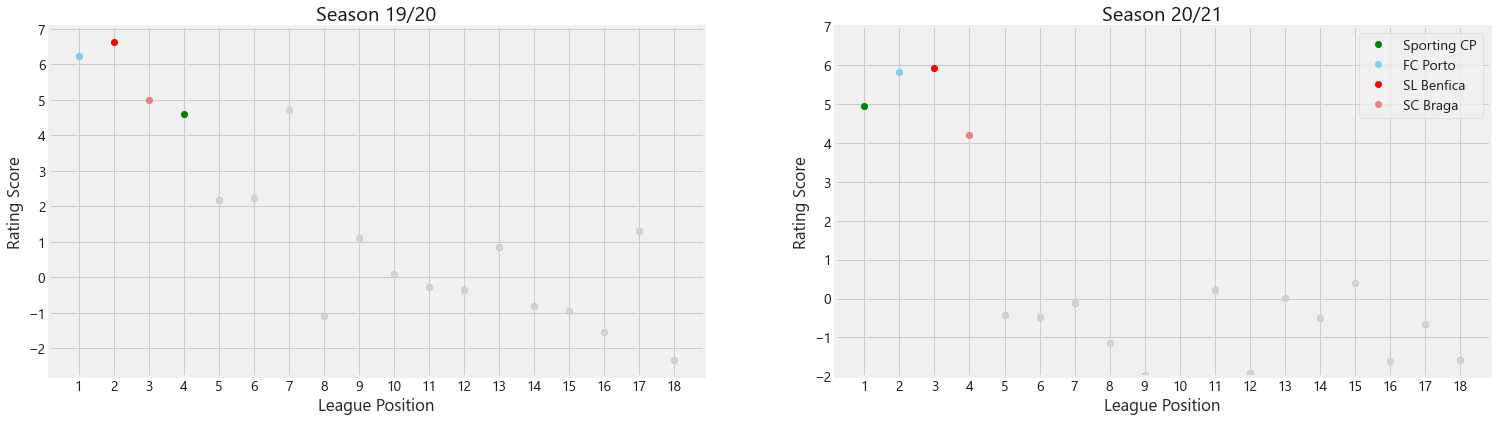

<Figure size 432x288 with 0 Axes>

In [59]:
data2021 = df_final2021[['index', 'Total']].to_numpy()
data1920 = df_final1920[['index', 'Total']].to_numpy()
annotations2021 = df_final2021['Team'].head(4)
annotations1920 = df_final1920['Team'].head(4)

fig = plt.figure(figsize=(23, 6))
ax1 = fig.add_subplot(121, title = 'Season 19/20', xlabel = 'League Position', ylabel = 'Rating Score')
ax2 = fig.add_subplot(122, title = 'Season 20/21', xlabel = 'League Position', ylabel = 'Rating Score')
ax1.scatter(data1920[:,0], data1920[:,1])
ax1.set_yticks(range(-2, 8))
ax1.set_xticks(range(0, 25))
ax2.scatter(data2021[:,0], data2021[:,1])
ax2.set_yticks(range(-2, 8))
ax2.set_xticks(range(0, 25))

for xy, color in zip(data1920, colors1920):
    ax1.plot(xy[0], xy[1], 'o', color = color, picker=True)
for xy, color in zip(data2021, colors2021):
    ax2.plot(xy[0], xy[1], 'o', color = color, picker=True)
    
plt.legend(annotations2021, loc = "upper right")
plt.ylim(-2, 7)
plt.show()

plt.savefig(r'C:\Users\pedro\OneDrive\Ambiente de Trabalho\Nova IMS\Programming for Data Science\Projeto\ProjetoProgramming\Myth3.png')

Analysing the charts, it is clear to see that Sporting it is playing better when compared to its previous season!

### MYTH BUSTED !

In [60]:
end = time.time()
print((end - start) / 60)

1.3774249076843261
